In [25]:
#Door_Dash_Revised
#This version will implement proper feature selection methods
#Train random forest, xgboost , linear regression, and neural networks to the doordash dataset

In [26]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from scipy.stats import sem
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
import datetime as dt

In [161]:
#Create a pandas dataframe 
dash_data = pd.read_csv("/Users/user/Downloads/historical_data.csv")

dash_data = pd.DataFrame(dash_data)

dash_data.head(5)

market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In [162]:
#convert times to datetime format so we can preform operation
dash_data['created_at'] = pd.to_datetime(dash_data['created_at'], format="%Y-%m-%d %H:%M:%S")
dash_data['actual_delivery_time'] = pd.to_datetime(dash_data['actual_delivery_time'], format="%Y-%m-%d %H:%M:%S")

#Insert a new column that represents the total time it takes to arrive
#We do this by subtracting the starting time and the actual delivery time
y =(dash_data['actual_delivery_time']-dash_data['created_at']).dt.total_seconds()
dash_data.insert(3 , "time_to_arrive" ,y)
dash_data.head(5)



market_id          created_at actual_delivery_time  time_to_arrive  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16          3779.0   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29          4024.0   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09          1781.0   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00          3075.0   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26          2390.0   

   store_id store_primary_category  order_protocol  total_items  subtotal  \
0      1845               american             1.0            4      3441   
1      5477                mexican             2.0            1      1900   
2      5477                    NaN             1.0            1      1900   
3      5477                    NaN             1.0            6      6900   
4      5477                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In [163]:
#The 'created_at' feature might be of importance but should only extract the time

#Take the just the time in hours, mintues and second
y = dash_data["created_at"].dt.strftime('%H:%M:%S')
dash_data.insert(3 , "created_at_hour", y)


In [164]:
#Take the Year, month and day from the "created_at" feature
x = dash_data["created_at"].dt.strftime("%Y-%m-%d")
dash_data.insert(4,"created_at_day" , x )


In [165]:
#View results
dash_data.head(5)

market_id          created_at actual_delivery_time created_at_hour  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:27:16        22:24:17   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:56:29        21:49:25   
2        3.0 2015-01-22 20:39:28  2015-01-22 21:09:09        20:39:28   
3        3.0 2015-02-03 21:21:45  2015-02-03 22:13:00        21:21:45   
4        3.0 2015-02-15 02:40:36  2015-02-15 03:20:26        02:40:36   

  created_at_day  time_to_arrive  store_id store_primary_category  \
0     2015-02-06          3779.0      1845               american   
1     2015-02-10          4024.0      5477                mexican   
2     2015-01-22          1781.0      5477                    NaN   
3     2015-02-03          3075.0      5477                    NaN   
4     2015-02-15          2390.0      5477                    NaN   

   order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0             1.0            4      3441                   4             557   
1             2.0            1      1900                   1            1400   
2             1.0            1      1900                   1            1900   
3             1.0            6      6900                   5             600   
4             1.0            3      3900                   3            1100   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1900                    1.0                 0.0   
3            1800                    1.0                 1.0   
4            1600                    6.0                 6.0   

   total_outstanding_orders  estimated_order_place_duration  \
0                      21.0                             446   
1                       2.0                             446   
2                       0.0                             446   
3                       2.0                             446   
4                       9.0                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In [166]:
#Create a new feature that represents the number of availible doordashers (total_onshift_dashers/(total_busy_dashers))
ratio_free_dashers = dash_data["total_busy_dashers"]/dash_data["total_onshift_dashers"]
ratio_free_dashers
dash_data.insert(14 , "total_free_dashers" ,ratio_free_dashers)


In [167]:
null_count = dash_data.isna().sum()
print(null_count)

market_id                                         987
created_at                                          0
actual_delivery_time                                7
created_at_hour                                     0
created_at_day                                      0
time_to_arrive                                      7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_free_dashers                              19838
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_durati

In [168]:
#Drop all NaN values from feature with less then 1000
dash_data.dropna(subset=["estimated_store_to_consumer_driving_duration","market_id","order_protocol",'time_to_arrive'], inplace=True)


In [169]:
null_count = dash_data.isna().sum()
null_count

market_id                                           0
created_at                                          0
actual_delivery_time                                0
created_at_hour                                     0
created_at_day                                      0
time_to_arrive                                      0
store_id                                            0
store_primary_category                           3995
order_protocol                                      0
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_free_dashers                              19654
total_onshift_dashers                           16107
total_busy_dashers                              16107
total_outstanding_orders                        16107
estimated_order_place_durati

In [170]:
#There are some concerning missing NaN values in the "total_onshift_dashers" , "total_busy_dashers", "total_outstanding_orders"
#Check the distribution of these variables

#Create a version of the data set without the dropped values
dash_data_free = dash_data.dropna()



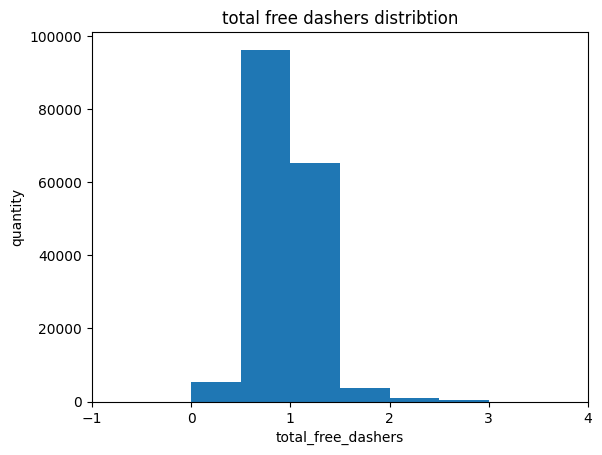

In [171]:
#Plot values of interest
plt.hist(dash_data_free["total_free_dashers"],bins=[0,0.5,1,1.5,2,2.5,3])
plt.title("total free dashers distribtion")
plt.xlabel("total_free_dashers")
plt.ylabel('quantity')
plt.xlim(-1,4)
plt.show()

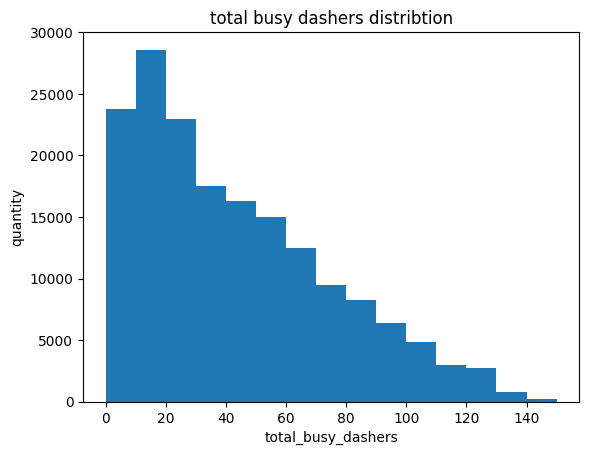

In [38]:
plt.hist(dash_data_free["total_busy_dashers"],bins=range(0,160,10))
plt.title("total busy dashers distribtion")
plt.xlabel("total_busy_dashers")
plt.ylabel('quantity')
plt.show()


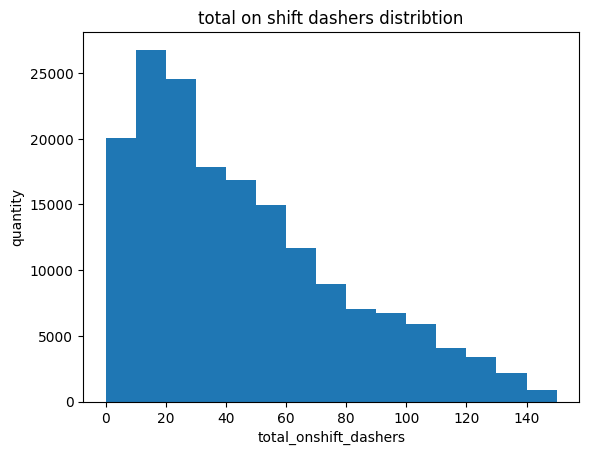

In [39]:
plt.hist(dash_data_free["total_onshift_dashers"],bins=range(0,160,10))
plt.title("total on shift dashers distribtion")
plt.xlabel("total_onshift_dashers")
plt.ylabel('quantity')
plt.show()


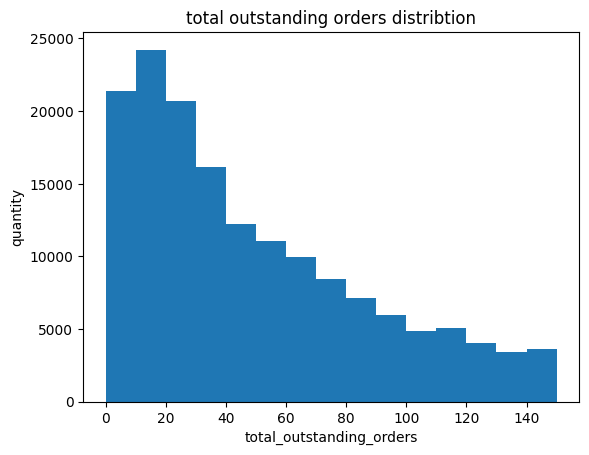

In [40]:
plt.hist(dash_data_free['total_outstanding_orders'],bins=range(0,160,10))
plt.title("total outstanding orders distribtion")
plt.xlabel('total_outstanding_orders')
plt.ylabel('quantity')
plt.show()


In [172]:
#Observe, right skewed data.  Impute using Median and adjust the "free_dashers" column acc0rdingly
dash_data["total_busy_dashers"] = dash_data["total_busy_dashers"].fillna(dash_data["total_busy_dashers"].median())
dash_data["total_onshift_dashers"] = dash_data["total_onshift_dashers"].fillna(dash_data["total_onshift_dashers"].median())
dash_data['total_outstanding_orders'] = dash_data["total_outstanding_orders"].fillna(dash_data["total_outstanding_orders"].median())
dash_data["total_free_dashers"] = dash_data["total_busy_dashers"]/dash_data["total_onshift_dashers"]
dash_data["total_busy_dashers"].isnull().sum()

0

In [173]:
#Drop all values in which total_onshift_dashers is 0 since that would result in a NaN value for total_free_dashers
dash_data.loc[dash_data["total_onshift_dashers"] == 0] = None

dash_data.dropna(subset="total_free_dashers" , inplace = True)

In [174]:
dash_data.isnull().sum()

market_id                                          0
created_at                                         0
actual_delivery_time                               0
created_at_hour                                    0
created_at_day                                     0
time_to_arrive                                     0
store_id                                           0
store_primary_category                          3950
order_protocol                                     0
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_free_dashers                                 0
total_onshift_dashers                              0
total_busy_dashers                                 0
total_outstanding_orders                           0
estimated_order_place_duration                

In [175]:
#For now, drop the null values for the store primary category so we cna visualize
dash_data.dropna(inplace=True)

In [176]:
#Before moving on to deal with the Null values in "store_primary_category" apply some tests to visualize how the data if the data is at all seperated into classes
#Create data set with just numerical value
dash_data_numeric = dash_data[["max_item_price","min_item_price","num_distinct_items","time_to_arrive",	"subtotal",  "total_items"	,"total_free_dashers",	"total_outstanding_orders","total_onshift_dashers"  ,"total_busy_dashers",	"estimated_order_place_duration",	"estimated_store_to_consumer_driving_duration"]]

In [177]:
#Check how many categories there are for each category variable

#For store primary category
print(dash_data["store_primary_category"].value_counts().count())
#At most we should have 74

#For Market IDs
print(dash_data["market_id"].value_counts().count())

#For order_protocol
print(dash_data["order_protocol"].value_counts().count())


74
6
7


In [178]:
#K-means Clustering Elobow plot
#Scale data first
scaler = StandardScaler()
dash_data_numeric_scaled = scaler.fit_transform(dash_data_numeric)



c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

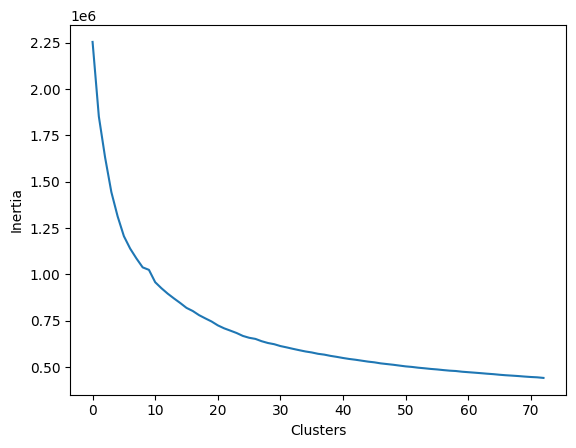

In [48]:
#Create an elbow plot to get a rough idea on how the data is split categorically (if at all) set the limit to 74 since thats the max amount of categorical variables 
elbow=[]
for i in range(1,74):
    kmeansmodel = KMeans(n_clusters = i , random_state=10)
    kmeansmodel.fit(dash_data_numeric_scaled)
    elbow.append(kmeansmodel.inertia_)

#Plot
plt.plot(elbow)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

In [49]:
print(dash_data_numeric.shape)
print(dash_data.shape)


(187866, 12)
(187866, 20)


In [179]:
#Use PCA to visualize data
#Create a new data frame with the order protocol variable

#Give dash_data and dash_data numeric a ID name so they can be merged
dash_data["ID"] = dash_data.index + 1
dash_data_numeric["ID"] = dash_data_numeric.index + 1
dash_data_for_pca = dash_data_numeric.merge(dash_data[['ID',"order_protocol"]], left_on="ID",right_on = "ID")
dash_data_for_pca

C:\Users\user\AppData\Local\Temp\ipykernel_15444\2495646655.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dash_data_numeric["ID"] = dash_data_numeric.index + 1


max_item_price  min_item_price  num_distinct_items  time_to_arrive  \
0               1239.0           557.0                 4.0          3779.0   
1               1400.0          1400.0                 1.0          4024.0   
2               1604.0           820.0                 3.0          1586.0   
3               1525.0          1525.0                 1.0          2273.0   
4               2195.0          1425.0                 2.0          2988.0   
...                ...             ...                 ...             ...   
187861           649.0           345.0                 3.0          3907.0   
187862           825.0           405.0                 4.0          3383.0   
187863           399.0           300.0                 3.0          3008.0   
187864           535.0           535.0                 1.0          3907.0   
187865           750.0           425.0                 4.0          2228.0   

        subtotal  total_items  total_free_dashers  total_outstanding_orders  \
0         3441.0          4.0            0.424242                      21.0   
1         1900.0          1.0            2.000000                       2.0   
2         4771.0          4.0            0.750000                      18.0   
3         1525.0          1.0            1.200000                       8.0   
4         3620.0          2.0            1.000000                       7.0   
...          ...          ...                 ...                       ...   
187861    1389.0          3.0            1.000000                      23.0   
187862    3010.0          6.0            0.916667                      14.0   
187863    1836.0          5.0            1.051282                      40.0   
187864    1175.0          1.0            1.000000                      12.0   
187865    2605.0          4.0            1.000000                      23.0   

        total_onshift_dashers  total_busy_dashers  \
0                        33.0                14.0   
1                         1.0                 2.0   
2                         8.0                 6.0   
3                         5.0                 6.0   
4                         5.0                 5.0   
...                       ...                 ...   
187861                   17.0                17.0   
187862                   12.0                11.0   
187863                   39.0                41.0   
187864                    7.0                 7.0   
187865                   20.0                20.0   

        estimated_order_place_duration  \
0                                446.0   
1                                446.0   
2                                446.0   
3                                446.0   
4                                446.0   
...                                ...   
187861                           251.0   
187862                           251.0   
187863                           251.0   
187864                           446.0   
187865                           446.0   

        estimated_store_to_consumer_driving_duration      ID  order_protocol  
0                                              861.0       1             1.0  
1                                              690.0       2             2.0  
2                                              289.0       9             3.0  
3                                              795.0      15             1.0  
4                                              205.0      16             1.0  
...                                              ...     ...             ...  
187861                                         331.0  197424             4.0  
187862                                         915.0  197425             4.0  
187863                                         795.0  197426             4.0  
187864                                         384.0  197427             1.0  
187865                                         134.0  197428             1.0  

[187866 rows x 14 columns]

In [180]:
dash_data_for_pca.drop(columns="ID")

max_item_price  min_item_price  num_distinct_items  time_to_arrive  \
0               1239.0           557.0                 4.0          3779.0   
1               1400.0          1400.0                 1.0          4024.0   
2               1604.0           820.0                 3.0          1586.0   
3               1525.0          1525.0                 1.0          2273.0   
4               2195.0          1425.0                 2.0          2988.0   
...                ...             ...                 ...             ...   
187861           649.0           345.0                 3.0          3907.0   
187862           825.0           405.0                 4.0          3383.0   
187863           399.0           300.0                 3.0          3008.0   
187864           535.0           535.0                 1.0          3907.0   
187865           750.0           425.0                 4.0          2228.0   

        subtotal  total_items  total_free_dashers  total_outstanding_orders  \
0         3441.0          4.0            0.424242                      21.0   
1         1900.0          1.0            2.000000                       2.0   
2         4771.0          4.0            0.750000                      18.0   
3         1525.0          1.0            1.200000                       8.0   
4         3620.0          2.0            1.000000                       7.0   
...          ...          ...                 ...                       ...   
187861    1389.0          3.0            1.000000                      23.0   
187862    3010.0          6.0            0.916667                      14.0   
187863    1836.0          5.0            1.051282                      40.0   
187864    1175.0          1.0            1.000000                      12.0   
187865    2605.0          4.0            1.000000                      23.0   

        total_onshift_dashers  total_busy_dashers  \
0                        33.0                14.0   
1                         1.0                 2.0   
2                         8.0                 6.0   
3                         5.0                 6.0   
4                         5.0                 5.0   
...                       ...                 ...   
187861                   17.0                17.0   
187862                   12.0                11.0   
187863                   39.0                41.0   
187864                    7.0                 7.0   
187865                   20.0                20.0   

        estimated_order_place_duration  \
0                                446.0   
1                                446.0   
2                                446.0   
3                                446.0   
4                                446.0   
...                                ...   
187861                           251.0   
187862                           251.0   
187863                           251.0   
187864                           446.0   
187865                           446.0   

        estimated_store_to_consumer_driving_duration  order_protocol  
0                                              861.0             1.0  
1                                              690.0             2.0  
2                                              289.0             3.0  
3                                              795.0             1.0  
4                                              205.0             1.0  
...                                              ...             ...  
187861                                         331.0             4.0  
187862                                         915.0             4.0  
187863                                         795.0             4.0  
187864                                         384.0             1.0  
187865                                         134.0             1.0  

[187866 rows x 13 columns]

In [181]:
#Generate PCA
pca_numerical,pca_protocol =dash_data_for_pca,dash_data_for_pca["order_protocol"] 
pca__scaled = scaler.fit_transform(pca_numerical)
pca = PCA()
pca_dash =pca.fit_transform(pca__scaled)


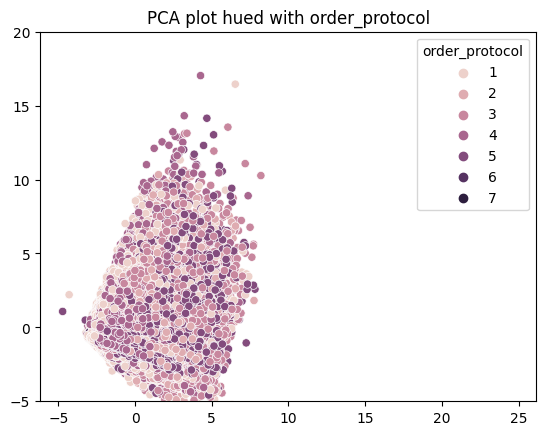

In [113]:
sns.scatterplot(x = pca_dash[:,0] , y = pca_dash[:,1], hue=pca_protocol)
plt.ylim([-5,20])
plt.title("PCA plot hued with order_protocol")
plt.show()



In [98]:
dash_data_numeric

max_item_price  min_item_price  num_distinct_items  time_to_arrive  \
0               1239.0           557.0                 4.0          3779.0   
1               1400.0          1400.0                 1.0          4024.0   
8               1604.0           820.0                 3.0          1586.0   
14              1525.0          1525.0                 1.0          2273.0   
15              2195.0          1425.0                 2.0          2988.0   
...                ...             ...                 ...             ...   
197423           649.0           345.0                 3.0          3907.0   
197424           825.0           405.0                 4.0          3383.0   
197425           399.0           300.0                 3.0          3008.0   
197426           535.0           535.0                 1.0          3907.0   
197427           750.0           425.0                 4.0          2228.0   

        subtotal  total_items  total_free_dashers  total_outstanding_orders  \
0         3441.0          4.0            0.424242                      21.0   
1         1900.0          1.0            2.000000                       2.0   
8         4771.0          4.0            0.750000                      18.0   
14        1525.0          1.0            1.200000                       8.0   
15        3620.0          2.0            1.000000                       7.0   
...          ...          ...                 ...                       ...   
197423    1389.0          3.0            1.000000                      23.0   
197424    3010.0          6.0            0.916667                      14.0   
197425    1836.0          5.0            1.051282                      40.0   
197426    1175.0          1.0            1.000000                      12.0   
197427    2605.0          4.0            1.000000                      23.0   

        total_onshift_dashers  total_busy_dashers  \
0                        33.0                14.0   
1                         1.0                 2.0   
8                         8.0                 6.0   
14                        5.0                 6.0   
15                        5.0                 5.0   
...                       ...                 ...   
197423                   17.0                17.0   
197424                   12.0                11.0   
197425                   39.0                41.0   
197426                    7.0                 7.0   
197427                   20.0                20.0   

        estimated_order_place_duration  \
0                                446.0   
1                                446.0   
8                                446.0   
14                               446.0   
15                               446.0   
...                                ...   
197423                           251.0   
197424                           251.0   
197425                           251.0   
197426                           446.0   
197427                           446.0   

        estimated_store_to_consumer_driving_duration      ID  
0                                              861.0       1  
1                                              690.0       2  
8                                              289.0       9  
14                                             795.0      15  
15                                             205.0      16  
...                                              ...     ...  
197423                                         331.0  197424  
197424                                         915.0  197425  
197425                                         795.0  197426  
197426                                         384.0  197427  
197427                                         134.0  197428  

[187866 rows x 13 columns]

C:\Users\user\AppData\Local\Temp\ipykernel_15444\1519698991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dash_data_numeric["ID"] = dash_data_numeric.index + 1


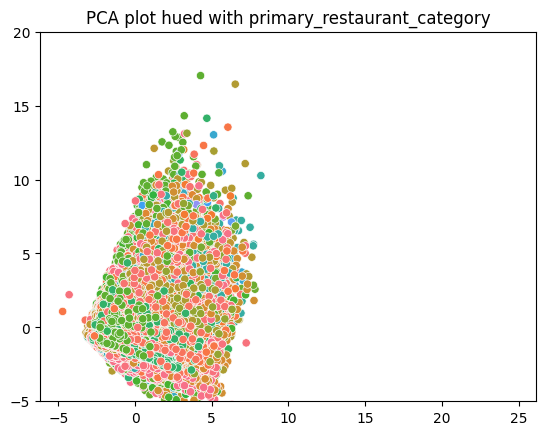

In [114]:
#Apply the hue for store_primary_category

dash_data["ID"] = dash_data.index + 1
dash_data_numeric["ID"] = dash_data_numeric.index + 1
dash_data_for_pca = dash_data_numeric.merge(dash_data[['ID',"store_primary_category"]], left_on="ID",right_on = "ID")

dash_data_for_pca.drop(columns="ID")

pca_numerical,pca_primary =dash_data_for_pca.drop(columns="store_primary_category"),dash_data_for_pca["store_primary_category"] 
pca__scaled = scaler.fit_transform(pca_numerical)
pca = PCA()
pca_dash =pca.fit_transform(pca__scaled)

sns.scatterplot(x = pca_dash[:,0] , y = pca_dash[:,1], hue=pca_primary, legend=False)
plt.title('PCA plot hued with primary_restaurant_category')
plt.ylim([-5,20])
plt.show()






C:\Users\user\AppData\Local\Temp\ipykernel_15444\1419742392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dash_data_numeric["ID"] = dash_data_numeric.index + 1


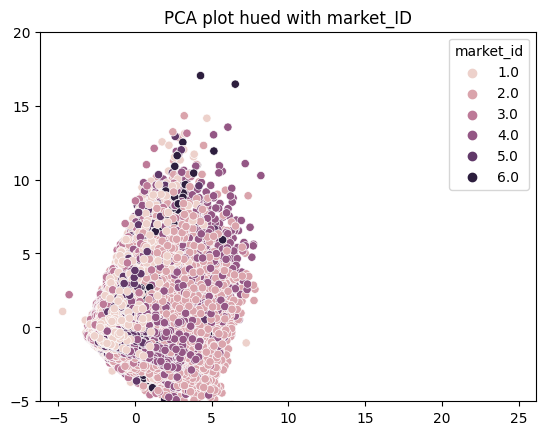

In [116]:
#Apply the hue for store_ID

dash_data["ID"] = dash_data.index + 1
dash_data_numeric["ID"] = dash_data_numeric.index + 1
dash_data_for_pca = dash_data_numeric.merge(dash_data[['ID',"market_id"]], left_on="ID",right_on = "ID")

dash_data_for_pca.drop(columns="ID")

pca_numerical,pca_primary =dash_data_for_pca.drop(columns="market_id"),dash_data_for_pca["market_id"] 
pca__scaled = scaler.fit_transform(pca_numerical)
pca = PCA()
pca_dash =pca.fit_transform(pca__scaled)

sns.scatterplot(x = pca_dash[:,0] , y = pca_dash[:,1], hue=pca_primary)
plt.title('PCA plot hued with market_ID')
plt.ylim([-5,20])
plt.show()



In [182]:
#Based on the visulization and the elbow plot, it is safe to remove the categorical variables as well as the created_at and actual_delivery_time
dash_data_new = dash_data.drop(columns=["order_protocol","market_id","actual_delivery_time","store_id","store_primary_category","order_protocol","ID"])
dash_data_new.head(10)

created_at created_at_hour created_at_day  time_to_arrive  \
0  2015-02-06 22:24:17        22:24:17     2015-02-06          3779.0   
1  2015-02-10 21:49:25        21:49:25     2015-02-10          4024.0   
8  2015-02-16 00:11:35        00:11:35     2015-02-16          1586.0   
14 2015-02-12 03:36:46        03:36:46     2015-02-12          2273.0   
15 2015-01-27 02:12:36        02:12:36     2015-01-27          2988.0   
16 2015-02-06 00:42:42        00:42:42     2015-02-06          5267.0   
17 2015-02-08 02:04:17        02:04:17     2015-02-08          4976.0   
18 2015-01-31 04:35:54        04:35:54     2015-01-31          4296.0   
19 2015-01-31 02:21:23        02:21:23     2015-01-31          3019.0   
20 2015-01-31 23:45:12        23:45:12     2015-01-31          1733.0   

    total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0           4.0    3441.0                 4.0           557.0          1239.0   
1           1.0    1900.0                 1.0          1400.0          1400.0   
8           4.0    4771.0                 3.0           820.0          1604.0   
14          1.0    1525.0                 1.0          1525.0          1525.0   
15          2.0    3620.0                 2.0          1425.0          2195.0   
16          3.0    4475.0                 3.0           925.0          1825.0   
17          3.0    4375.0                 3.0          1325.0          1625.0   
18          2.0    3150.0                 2.0          1425.0          1725.0   
19          2.0     950.0                 2.0           150.0           700.0   
20          5.0    1285.0                 3.0           150.0           400.0   

    total_free_dashers  total_onshift_dashers  total_busy_dashers  \
0             0.424242                   33.0                14.0   
1             2.000000                    1.0                 2.0   
8             0.750000                    8.0                 6.0   
14            1.200000                    5.0                 6.0   
15            1.000000                    5.0                 5.0   
16            0.250000                    4.0                 1.0   
17            0.666667                    6.0                 4.0   
18            2.250000                    4.0                 9.0   
19            1.000000                   24.0                24.0   
20            1.083333                   12.0                13.0   

    total_outstanding_orders  estimated_order_place_duration  \
0                       21.0                           446.0   
1                        2.0                           446.0   
8                       18.0                           446.0   
14                       8.0                           446.0   
15                       7.0                           446.0   
16                       1.0                           446.0   
17                       3.0                           446.0   
18                      12.0                           446.0   
19                      26.0                           446.0   
20                      11.0                           446.0   

    estimated_store_to_consumer_driving_duration  
0                                          861.0  
1                                          690.0  
8                                          289.0  
14                                         795.0  
15                                         205.0  
16                                         542.0  
17                                         789.0  
18                                         548.0  
19                                         212.0  
20                                         424.0

In [183]:
dash_data_new.drop(columns="created_at", inplace=True)

In [56]:
dash_data_new

created_at_hour created_at_day  time_to_arrive  total_items  subtotal  \
0             22:24:17     2015-02-06          3779.0          4.0    3441.0   
1             21:49:25     2015-02-10          4024.0          1.0    1900.0   
8             00:11:35     2015-02-16          1586.0          4.0    4771.0   
14            03:36:46     2015-02-12          2273.0          1.0    1525.0   
15            02:12:36     2015-01-27          2988.0          2.0    3620.0   
...                ...            ...             ...          ...       ...   
197423        00:19:41     2015-02-17          3907.0          3.0    1389.0   
197424        00:01:59     2015-02-13          3383.0          6.0    3010.0   
197425        04:46:08     2015-01-24          3008.0          5.0    1836.0   
197426        18:18:15     2015-02-01          3907.0          1.0    1175.0   
197427        19:24:33     2015-02-08          2228.0          4.0    2605.0   

        num_distinct_items  min_item_price  max_item_price  \
0                      4.0           557.0          1239.0   
1                      1.0          1400.0          1400.0   
8                      3.0           820.0          1604.0   
14                     1.0          1525.0          1525.0   
15                     2.0          1425.0          2195.0   
...                    ...             ...             ...   
197423                 3.0           345.0           649.0   
197424                 4.0           405.0           825.0   
197425                 3.0           300.0           399.0   
197426                 1.0           535.0           535.0   
197427                 4.0           425.0           750.0   

        total_free_dashers  total_onshift_dashers  total_busy_dashers  \
0                 0.424242                   33.0                14.0   
1                 2.000000                    1.0                 2.0   
8                 0.750000                    8.0                 6.0   
14                1.200000                    5.0                 6.0   
15                1.000000                    5.0                 5.0   
...                    ...                    ...                 ...   
197423            1.000000                   17.0                17.0   
197424            0.916667                   12.0                11.0   
197425            1.051282                   39.0                41.0   
197426            1.000000                    7.0                 7.0   
197427            1.000000                   20.0                20.0   

        total_outstanding_orders  estimated_order_place_duration  \
0                           21.0                           446.0   
1                            2.0                           446.0   
8                           18.0                           446.0   
14                           8.0                           446.0   
15                           7.0                           446.0   
...                          ...                             ...   
197423                      23.0                           251.0   
197424                      14.0                           251.0   
197425                      40.0                           251.0   
197426                      12.0                           446.0   
197427                      23.0                           446.0   

        estimated_store_to_consumer_driving_duration  
0                                              861.0  
1                                              690.0  
8                                              289.0  
14                                             795.0  
15                                             205.0  
...                                              ...  
197423                                         331.0  
197424                                         915.0  
197425                                         795.0  
197426                                         384.0  
19

In [184]:
#Test for multicollinearity, first split date time into hour and minute
dash_data_new["hour"] = dash_data["created_at"].dt.strftime('%H')
dash_data_new["minute"] = dash_data["created_at"].dt.strftime('%M')

dash_data_new.head(1)

created_at_hour created_at_day  time_to_arrive  total_items  subtotal  \
0        22:24:17     2015-02-06          3779.0          4.0    3441.0   

   num_distinct_items  min_item_price  max_item_price  total_free_dashers  \
0                 4.0           557.0          1239.0            0.424242   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   

   estimated_order_place_duration  \
0                           446.0   

   estimated_store_to_consumer_driving_duration hour minute  
0                                         861.0   22     24

In [185]:
#Get rid of date time variables, this includes the created_at_day and variables like it
dash_data_train = dash_data_new.drop(columns=['created_at_hour','created_at_day'])

In [186]:
#Create a copy of data
dash_data_org = dash_data_train

#Change date time variables to numerics
dash_data_train = dash_data_train.astype('float64', copy=True)

In [187]:
dash_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187866 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   time_to_arrive                                187866 non-null  float64
 1   total_items                                   187866 non-null  float64
 2   subtotal                                      187866 non-null  float64
 3   num_distinct_items                            187866 non-null  float64
 4   min_item_price                                187866 non-null  float64
 5   max_item_price                                187866 non-null  float64
 6   total_free_dashers                            187866 non-null  float64
 7   total_onshift_dashers                         187866 non-null  float64
 8   total_busy_dashers                            187866 non-null  float64
 9   total_outstanding_orders                      18

In [189]:
#Test for multicollinearity
#Create function that tests for collinearity between variables
#First we want to remove the redundancies in our correlation matrix
def remove_redundant(df):
    labels_drop = set()
    col = df.columns
#Want to iterate through the columns
    for i in range(df.shape[1]):
        for j in range(0,i+1):
        #Add to the drop list all the values on the diagnal and above.  Since we will have redundant terms
            labels_drop.add((col[i] , col[j]))
    return labels_drop

def create_corr_ranking(df , n=10):
    #Get the absolute value of the correlation matrix and format it as a vertical list
    abs_corr = df.corr().abs().unstack()
    #Call the function we used recently to remove duplicated
    drop = remove_redundant(df)
    #Drop all the redundant (and identity) pairs and make sure to from highest to smallest
    abs_corr = abs_corr.drop(labels = drop).sort_values(ascending = False)
    return abs_corr[0:n]


In [190]:
rank_dash = create_corr_ranking(dash_data_train , n=10)
rank_dash

total_onshift_dashers  total_busy_dashers          0.942036
                       total_outstanding_orders    0.934746
total_busy_dashers     total_outstanding_orders    0.931509
total_items            num_distinct_items          0.760825
subtotal               num_distinct_items          0.682125
total_items            subtotal                    0.555243
min_item_price         max_item_price              0.542474
subtotal               max_item_price              0.506313
num_distinct_items     min_item_price              0.450190
total_items            min_item_price              0.393214
dtype: float64

In [191]:
#Create some new features, first of all total_onshift and total busy can be quantified using total_free
#Drop otal_onshift and total_busy
dash_data_train.drop(columns=["total_onshift_dashers","total_busy_dashers"],inplace=True)
dash_data_train.head(1)

time_to_arrive  total_items  subtotal  num_distinct_items  min_item_price  \
0          3779.0          4.0    3441.0                 4.0           557.0   

   max_item_price  total_free_dashers  total_outstanding_orders  \
0          1239.0            0.424242                      21.0   

   estimated_order_place_duration  \
0                           446.0   

   estimated_store_to_consumer_driving_duration  hour  minute  
0                                         861.0  22.0    24.0

In [192]:
rank_dash_1 = create_corr_ranking(dash_data_train , n=20)
rank_dash_1

total_items               num_distinct_items                0.760825
subtotal                  num_distinct_items                0.682125
total_items               subtotal                          0.555243
min_item_price            max_item_price                    0.542474
subtotal                  max_item_price                    0.506313
num_distinct_items        min_item_price                    0.450190
total_items               min_item_price                    0.393214
total_outstanding_orders  hour                              0.353221
max_item_price            hour                              0.186932
subtotal                  hour                              0.184285
total_outstanding_orders  estimated_order_place_duration    0.164354
subtotal                  total_outstanding_orders          0.128908
max_item_price            total_outstanding_orders          0.126079
num_distinct_items        hour                              0.113978
max_item_price            estimate

In [193]:
#Create a new feature called 'ratio_distinct'
dash_data_train["ratio_distinct"] = dash_data_train["num_distinct_items"]/dash_data_train["total_items"]

In [67]:
#Drop total_items and num_distince
dash_data_train.drop(columns=["total_items","num_distinct_items"],inplace=True)

In [194]:
rank_dash_2 = create_corr_ranking(dash_data_train,n=10)
rank_dash_2

total_items               num_distinct_items    0.760825
subtotal                  num_distinct_items    0.682125
total_items               subtotal              0.555243
min_item_price            max_item_price        0.542474
subtotal                  max_item_price        0.506313
num_distinct_items        min_item_price        0.450190
total_items               ratio_distinct        0.448830
                          min_item_price        0.393214
total_outstanding_orders  hour                  0.353221
subtotal                  ratio_distinct        0.200403
dtype: float64

In [195]:
#Create a new feature called take the range of the price of an item
dash_data_train["range_price"] = dash_data_train["max_item_price"] - dash_data_train["min_item_price"]

#Drop the max and min price
dash_data_train.drop(columns=["max_item_price","min_item_price"],inplace=True)

In [196]:
dash_data_train.head(10)

time_to_arrive  total_items  subtotal  num_distinct_items  \
0           3779.0          4.0    3441.0                 4.0   
1           4024.0          1.0    1900.0                 1.0   
8           1586.0          4.0    4771.0                 3.0   
14          2273.0          1.0    1525.0                 1.0   
15          2988.0          2.0    3620.0                 2.0   
16          5267.0          3.0    4475.0                 3.0   
17          4976.0          3.0    4375.0                 3.0   
18          4296.0          2.0    3150.0                 2.0   
19          3019.0          2.0     950.0                 2.0   
20          1733.0          5.0    1285.0                 3.0   

    total_free_dashers  total_outstanding_orders  \
0             0.424242                      21.0   
1             2.000000                       2.0   
8             0.750000                      18.0   
14            1.200000                       8.0   
15            1.000000                       7.0   
16            0.250000                       1.0   
17            0.666667                       3.0   
18            2.250000                      12.0   
19            1.000000                      26.0   
20            1.083333                      11.0   

    estimated_order_place_duration  \
0                            446.0   
1                            446.0   
8                            446.0   
14                           446.0   
15                           446.0   
16                           446.0   
17                           446.0   
18                           446.0   
19                           446.0   
20                           446.0   

    estimated_store_to_consumer_driving_duration  hour  minute  \
0                                          861.0  22.0    24.0   
1                                          690.0  21.0    49.0   
8                                          289.0   0.0    11.0   
14                                         795.0   3.0    36.0   
15                                         205.0   2.0    12.0   
16                                         542.0   0.0    42.0   
17                                         789.0   2.0     4.0   
18                                         548.0   4.0    35.0   
19                                         212.0   2.0    21.0   
20                                         424.0  23.0    45.0   

    ratio_distinct  range_price  
0             1.00        682.0  
1             1.00          0.0  
8             0.75        784.0  
14            1.00          0.0  
15            1.00        770.0  
16            1.00        900.0  
17            1.00        300.0  
18            1.00        300.0  
19            1.00        550.0  
20            0.60        250.0

In [197]:
rank_dash_4 = create_corr_ranking(dash_data_train , n=10)
rank_dash_4

total_items               num_distinct_items    0.760825
subtotal                  num_distinct_items    0.682125
total_items               subtotal              0.555243
subtotal                  range_price           0.510971
num_distinct_items        range_price           0.501119
total_items               ratio_distinct        0.448830
total_outstanding_orders  hour                  0.353221
total_items               range_price           0.335006
subtotal                  ratio_distinct        0.200403
                          hour                  0.184285
dtype: float64

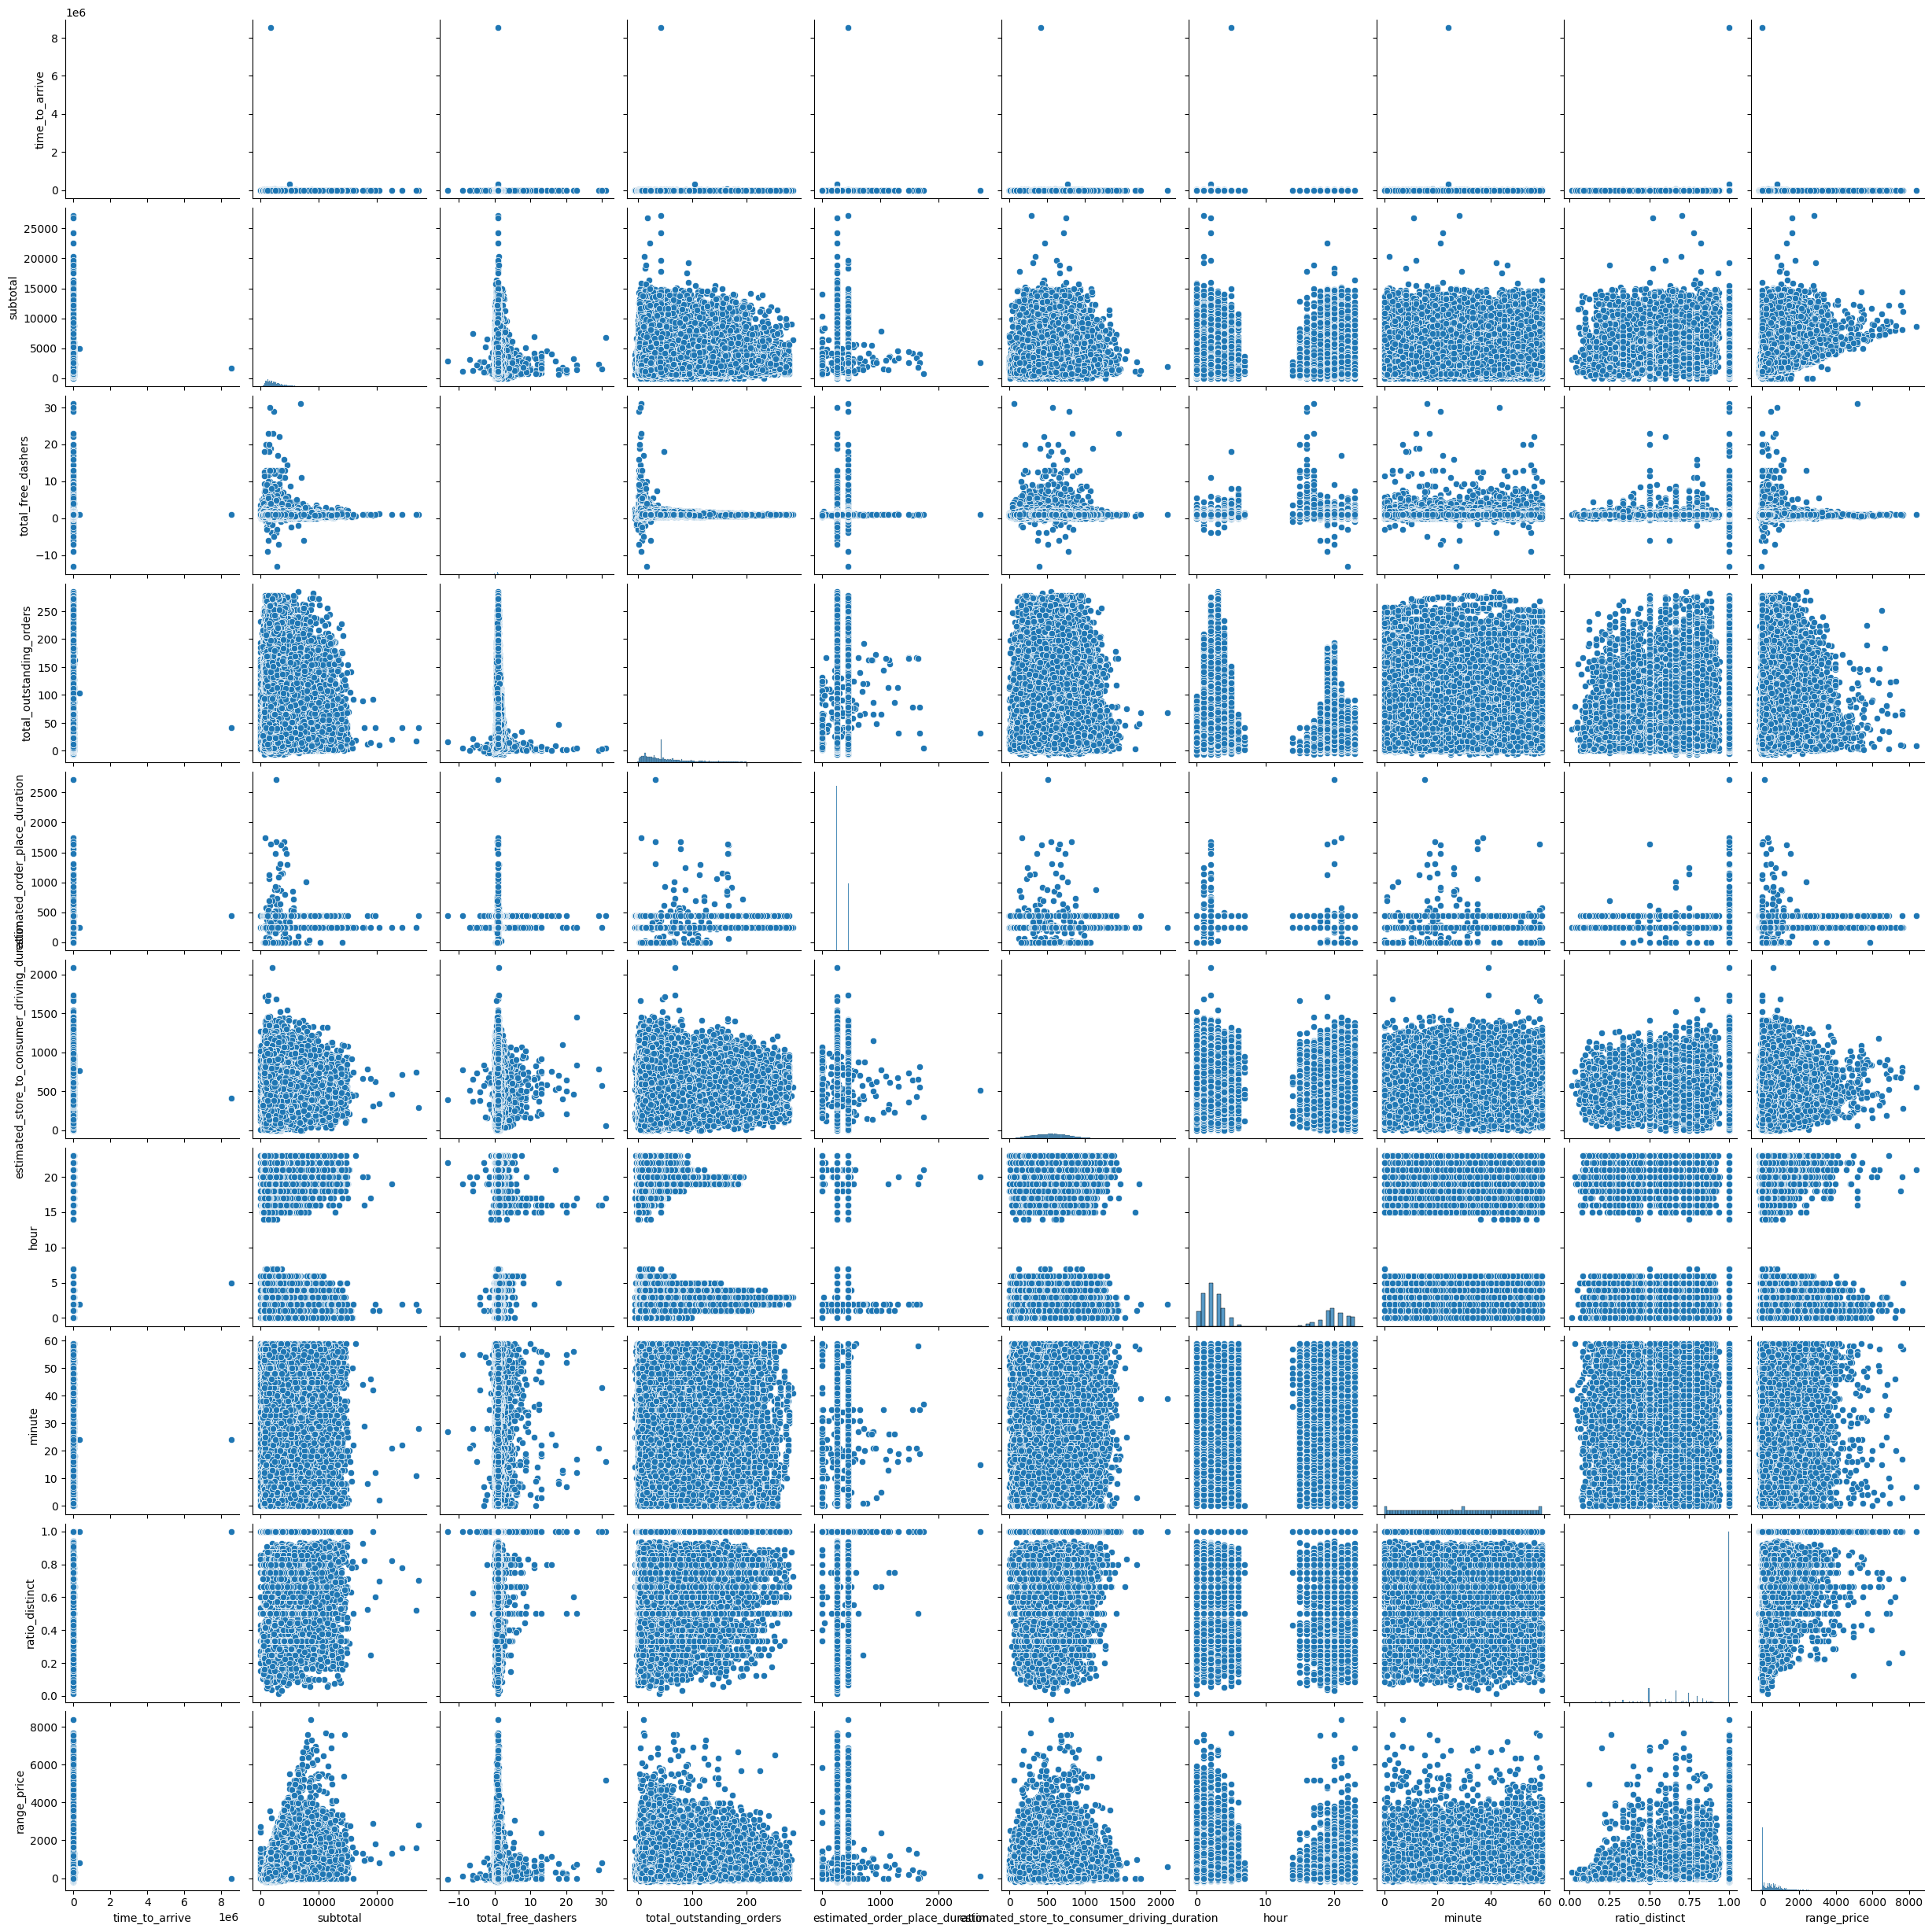

In [72]:
#The correlations look good, create a pairs plot of the dat
sns.pairplot(dash_data_train)
plt.show()

In [198]:
#Notice one outlier, remove
dash_data_train.loc[dash_data_train["time_to_arrive"] > 300000] = None
dash_data_train.dropna(inplace=True)

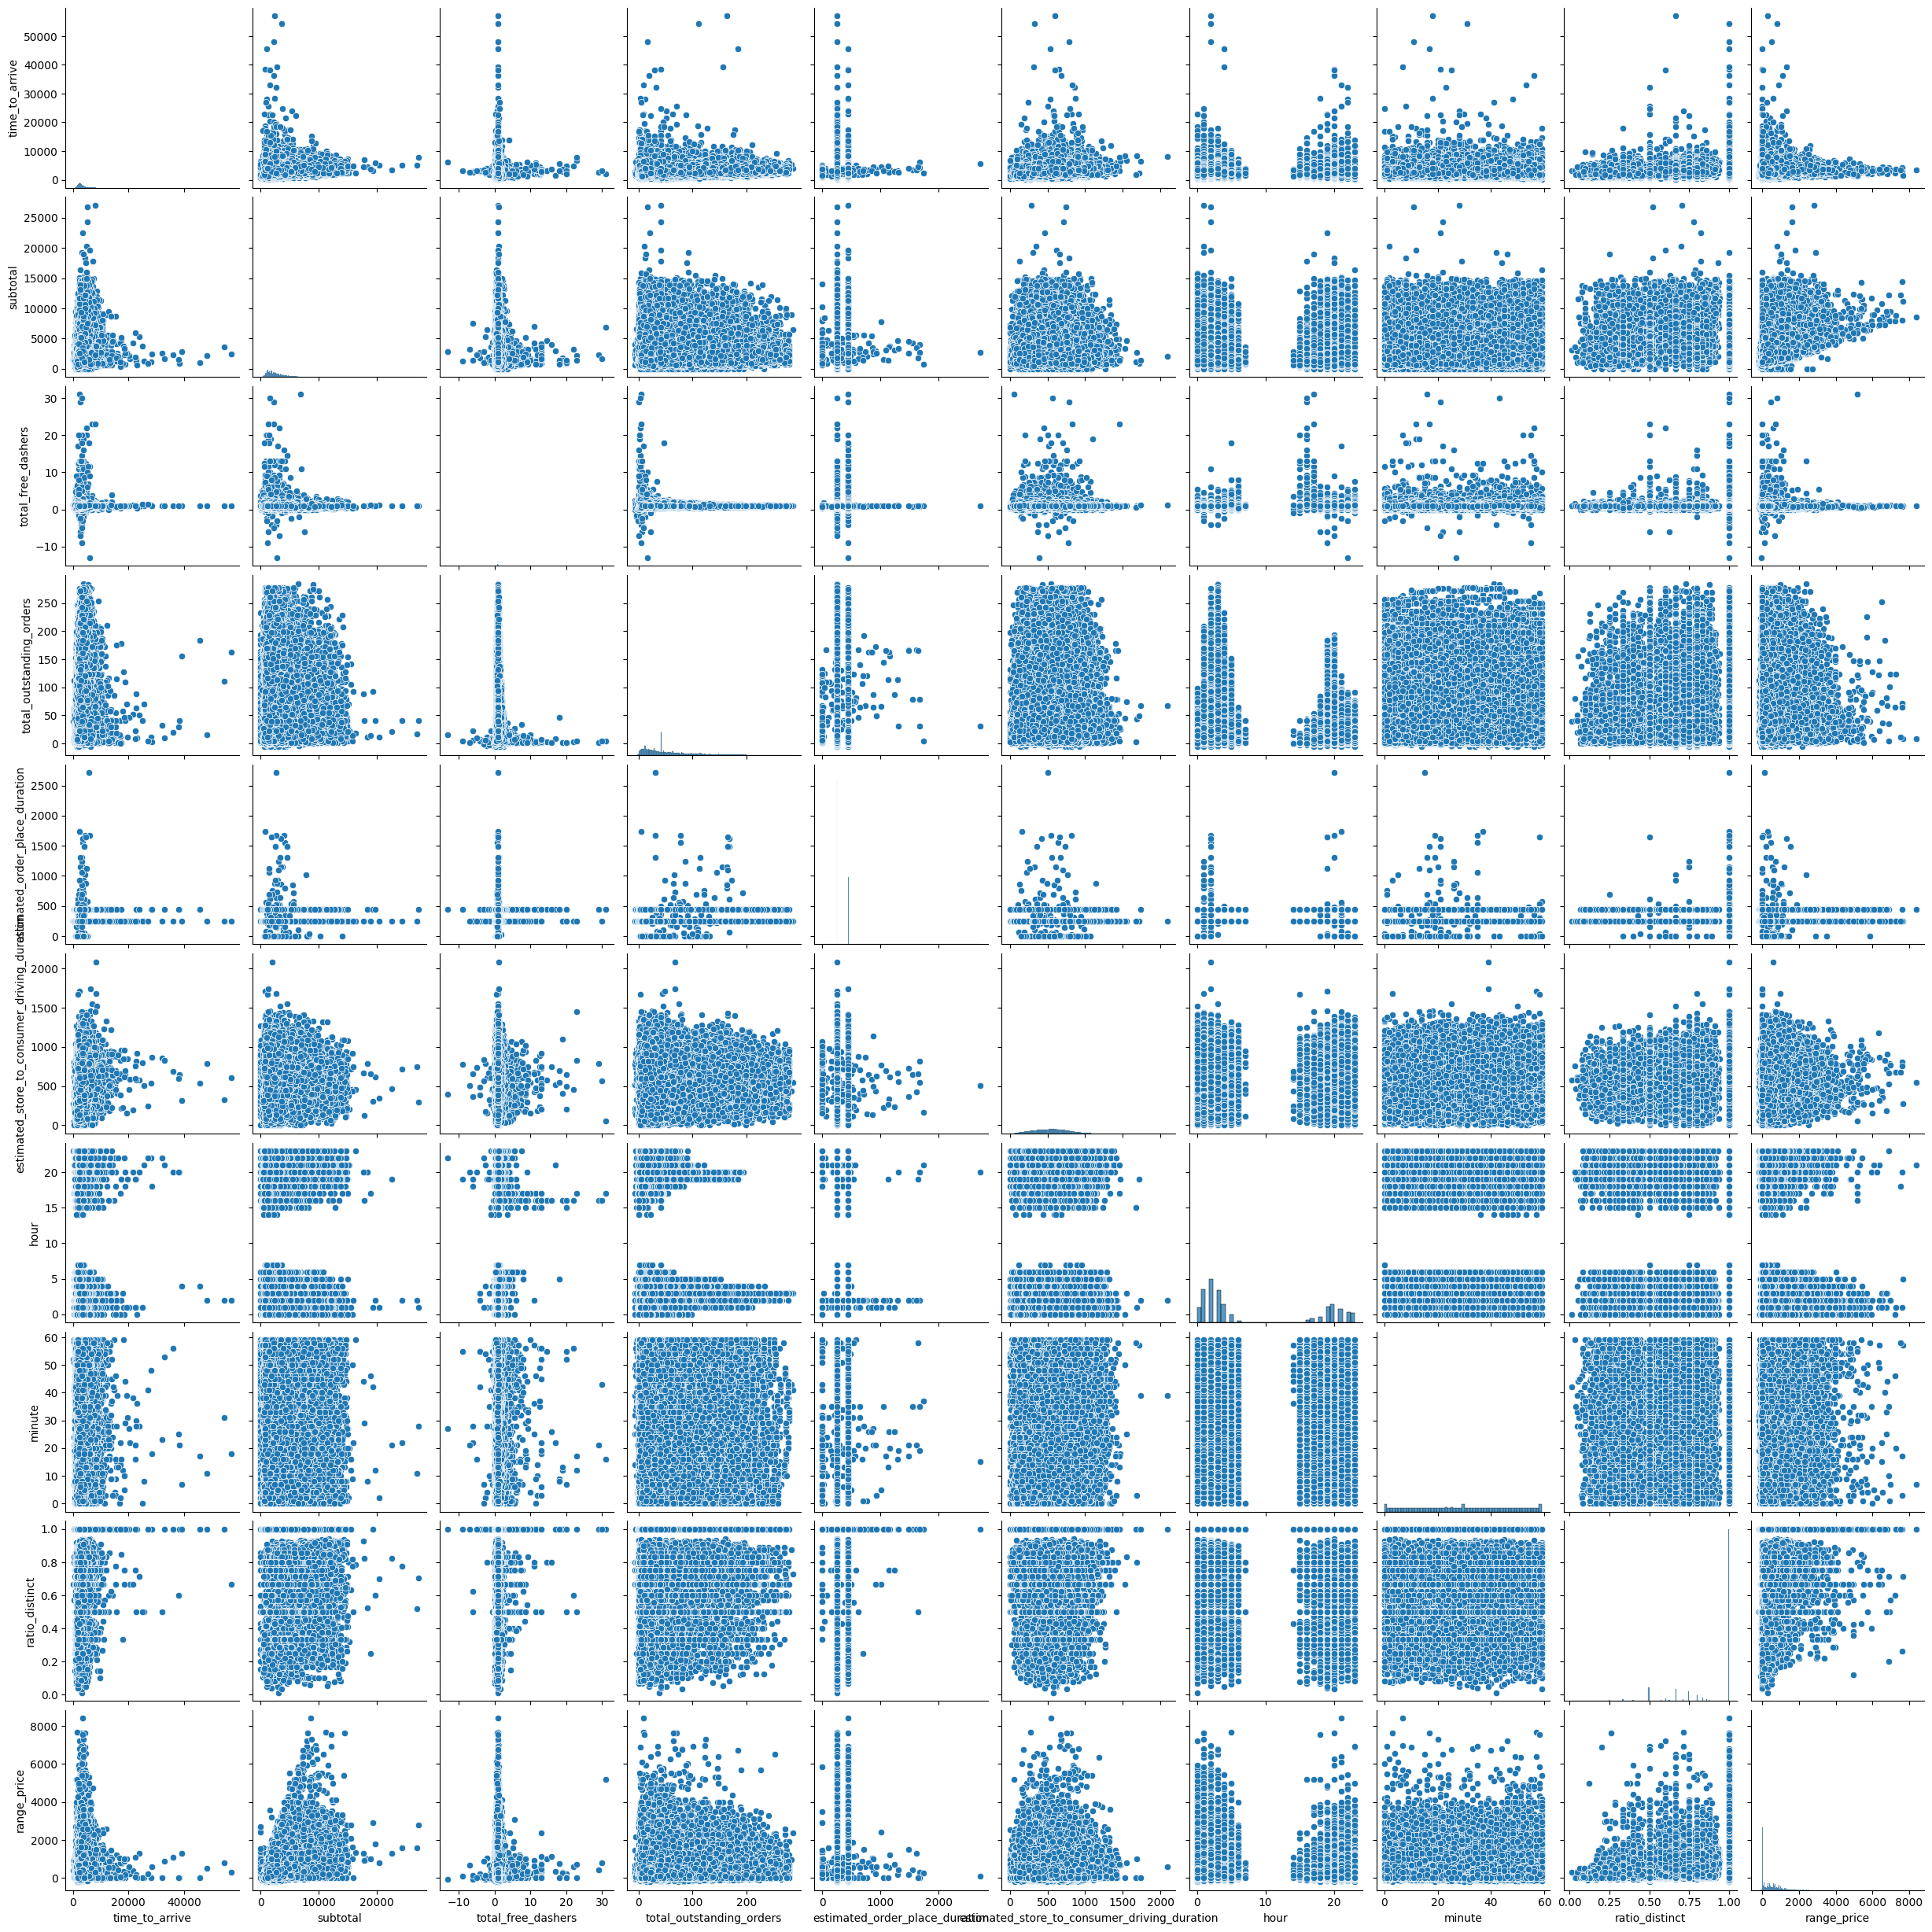

In [74]:
sns.pairplot(dash_data_train)
plt.show()

In [199]:
#Specify target variable
y = dash_data_train["time_to_arrive"]

#Specify predictors
x = dash_data_train.drop(columns="time_to_arrive")

In [200]:
#Split into test and training
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.2, random_state=100)

In [201]:
#Create function that fits a regression model and calculates RMSE
def regression(model,xtest,xtrain,ytrain,ytest):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    error = mean_squared_error(ytest , ypred,squared=True)
    rooterror = mean_squared_error(ytest , ypred,squared=False)
    
    r2 = r2_score(ytest , ypred)
    
    final_model = model
    return final_model,error,r2,rooterror

In [202]:
#Fit a linear regression
linear = regression(LinearRegression(),x_test , x_train , y_train , y_test)

#Check the RMSE
linear[3]

1059.4938278667648

In [203]:
#Create a validated Linear Regression model
validated_linear = cross_validate(LinearRegression(), x_train, y_train , cv=5,scoring='neg_root_mean_squared_error')

In [136]:
#Take the root mean squared error
print(validated_linear)
linear_score = abs(validated_linear["test_score"])

#Calculate the mean
mean = np.mean(linear_score)
print(mean)
print(linear_score)




{'fit_time': array([0.04585719, 0.03787327, 0.03488779, 0.03615832, 0.03787351]), 'score_time': array([0.00198531, 0.00199366, 0.00199032, 0.00199342, 0.00199223]), 'test_score': array([-1057.86803656, -1079.11839488, -1081.56978133, -1125.90249966,
       -1049.15598064])}
1078.7229386131
[1057.86803656 1079.11839488 1081.56978133 1125.90249966 1049.15598064]


In [80]:
#Fit a Random Forest
forest = regression(RandomForestRegressor(),x_test , x_train , y_train , y_test)

#Check the RMSE
forest[3]

1044.297948417155

In [81]:
#Cross Validate
#validated_forest = cross_validate(RandomForestRegressor(),x_train , y_train ,cv=5,scoring='neg_root_mean_squared_error')

In [82]:
mean_forest = np.mean([-1034.71447729, -1058.28434161, -1061.17492519, -1106.49492884,-1033.29396334])

-1058.792527254

In [138]:
forest_error = [1034.71447729, 1058.28434161, 1061.17492519, 1106.49492884,1033.29396334]


In [83]:
#Fit an XGBoost
train_reg = xgb.DMatrix(x_train , y_train)
test_reg = xgb.DMatrix(x_test, y_test)



In [84]:
#Before moving to cross validation lets tune our hyperparametres
#Use grid search to tune parametres, come up with some reasonable parametres
#params_tune = {'max_depth':[3,5,6,7,8],'learning_rate':[0.3,0.01,0.1,0.2],'n_estimators':[15,16,17,18],'subsample':[0.6,0.7,0.8]}

#specify the XGB regressor

#xgbr = xgb.XGBRegressor(seed=100)

#Run Grid search
#search = GridSearchCV(estimator=xgbr , param_grid=params_tune , scoring='neg_mean_squared_error',verbose=1)

#search.fit(x_train,y_train)

#search.best_params_

In [143]:
#Input Tuned Parametres into a cross validated Boosted Tree
tuned_params = {"objective":"reg:squarederror","tree_method":"gpu_hist",'learning_rate': 0.3, 'max_depth': 6, 'subsample': 0.8}

validated_model = xgb.cv(params=tuned_params , dtrain = train_reg , num_boost_round=100 ,nfold=5)

validated_model.min()

train-rmse-mean     942.888277
train-rmse-std        3.600961
test-rmse-mean     1036.741237
test-rmse-std        15.939239
dtype: float64

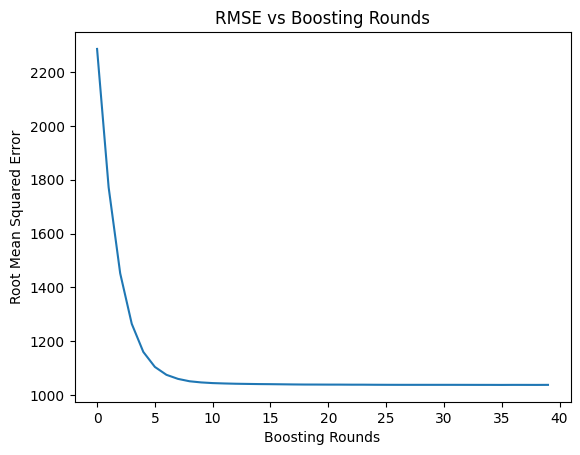

In [142]:
plt.plot(validated_model["test-rmse-mean"])
plt.title("RMSE vs Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("Root Mean Squared Error")
plt.show()

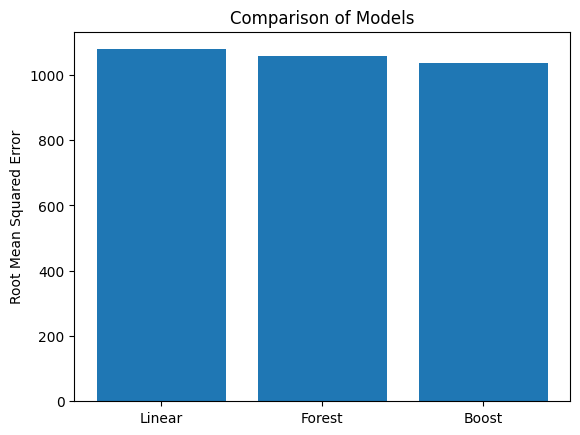

In [151]:
#Create a bar graph between the three means of the models
mean_dict = {'Linear':1078.722938613 , 'Forest':1058.792527254, 'Boost':1036.741237}
mean = list(mean_dict.values())
label = list(mean_dict.keys())

plt.bar(range(len(label)),mean , tick_label = label)
plt.title("Comparison of Models")
plt.ylabel("Root Mean Squared Error")
plt.show()

In [160]:
dash_data_train

time_to_arrive  total_items  subtotal  num_distinct_items  \
0               3779.0          4.0    3441.0                 4.0   
1               4024.0          1.0    1900.0                 1.0   
8               1586.0          4.0    4771.0                 3.0   
14              2273.0          1.0    1525.0                 1.0   
15              2988.0          2.0    3620.0                 2.0   
...                ...          ...       ...                 ...   
197423          3907.0          3.0    1389.0                 3.0   
197424          3383.0          6.0    3010.0                 4.0   
197425          3008.0          5.0    1836.0                 3.0   
197426          3907.0          1.0    1175.0                 1.0   
197427          2228.0          4.0    2605.0                 4.0   

        min_item_price  max_item_price  total_free_dashers  \
0                557.0          1239.0            0.424242   
1               1400.0          1400.0            2.000000   
8                820.0          1604.0            0.750000   
14              1525.0          1525.0            1.200000   
15              1425.0          2195.0            1.000000   
...                ...             ...                 ...   
197423           345.0           649.0            1.000000   
197424           405.0           825.0            0.916667   
197425           300.0           399.0            1.051282   
197426           535.0           535.0            1.000000   
197427           425.0           750.0            1.000000   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                        33.0                14.0                      21.0   
1                         1.0                 2.0                       2.0   
8                         8.0                 6.0                      18.0   
14                        5.0                 6.0                       8.0   
15                        5.0                 5.0                       7.0   
...                       ...                 ...                       ...   
197423                   17.0                17.0                      23.0   
197424                   12.0                11.0                      14.0   
197425                   39.0                41.0                      40.0   
197426                    7.0                 7.0                      12.0   
197427                   20.0                20.0                      23.0   

        estimated_order_place_duration  \
0                                446.0   
1                                446.0   
8                                446.0   
14                               446.0   
15                               446.0   
...                                ...   
197423                           251.0   
197424                           251.0   
197425                           251.0   
197426                           446.0   
197427                           446.0   

        estimated_store_to_consumer_driving_duration  hour  minute  
0                                              861.0  22.0    24.0  
1                                              690.0  21.0    49.0  
8                                              289.0   0.0    11.0  
14                                             795.0   3.0    36.0  
15                                             205.0   2.0    12.0  
...                                              ...   ...     ...  
197423                                         331.0   0.0    19.0  
197424                                         915.0   0.0     1.0  
197425                                         795.0   4.0    46.0  
197426                                         384.0  18.0    18.0  
197427                                         134.0  19.0    24.0  

[187864 rows x 14 columns]

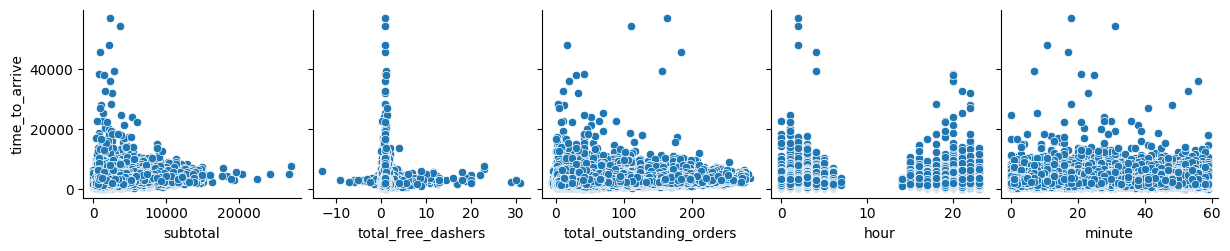

In [205]:
#Time to Arrival vs predictors
sns.pairplot(dash_data_train, y_vars='time_to_arrive', x_vars=['subtotal', 'total_free_dashers', 'total_outstanding_orders','hour','minute'])
plt.show()

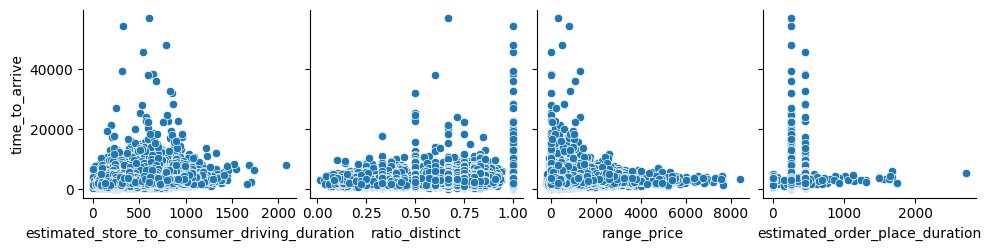

In [207]:
sns.pairplot(dash_data_train, y_vars='time_to_arrive', x_vars= ['estimated_store_to_consumer_driving_duration','ratio_distinct', 'range_price','estimated_order_place_duration'])
plt.show()

In [ ]:
['subtotal', 'total_free_dashers', 'total_outstanding_orders','hour','minute', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration','ratio_distinct', 'range_price']